In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [6]:
# Load the dataset
df = pd.read_csv("ebay_mens_perfume.csv")  # Change to your file path

# Drop unnecessary columns
df_cleaned = df.drop(columns=["priceWithCurrency", "availableText", "lastUpdated", "title"])

# Handle missing values
imputer = SimpleImputer(strategy="most_frequent")
df_cleaned[["brand", "type", "itemLocation"]] = imputer.fit_transform(df_cleaned[["brand", "type", "itemLocation"]])
df_cleaned[["available", "sold"]] = df_cleaned[["available", "sold"]].fillna(df_cleaned[["available", "sold"]].median())

# Encode categorical variables
label_encoders = {}
for col in ["brand", "type", "itemLocation"]:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

# Define features and target
X = df_cleaned.drop(columns=["price"])
y = df_cleaned["price"]

# Check the cleaned dataset
print(df_cleaned.head())


   brand  type   price  available   sold  itemLocation
0     68    25   84.99       10.0  116.0             5
1      3    25  109.99        8.0   48.0            13
2    223    29  100.00       10.0   27.0            59
3     96    29   44.99        2.0  159.0           210
4    141    44   16.91       10.0  156.0            25


In [7]:
# Define split ratios
split_ratios = {"80:20": 0.2, "75:25": 0.25, "70:30": 0.3}
splits = {}

# Perform train-test splits
for split_name, test_size in split_ratios.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    splits[split_name] = (X_train, X_test, y_train, y_test)

# Print dataset sizes
for split, (X_train, X_test, y_train, y_test) in splits.items():
    print(f"{split} -> Train: {len(X_train)}, Test: {len(X_test)}")


80:20 -> Train: 800, Test: 200
75:25 -> Train: 750, Test: 250
70:30 -> Train: 700, Test: 300


In [8]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression": SVR(kernel="rbf"),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

# Store model results
results = {}

# Train and evaluate each model
for split_name, (X_train, X_test, y_train, y_test) in splits.items():
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute evaluation metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Store results
        if model_name not in results:
            results[model_name] = {}
        results[model_name][split_name] = {"R2": r2, "MAE": mae, "RMSE": rmse}

# Print performance results
for model, metrics in results.items():
    print(f"\nModel: {model}")
    for split, scores in metrics.items():
        print(f"{split}: R2 = {scores['R2']:.4f}, MAE = {scores['MAE']:.4f}, RMSE = {scores['RMSE']:.4f}")



Model: Linear Regression
80:20: R2 = 0.0164, MAE = 24.6172, RMSE = 37.9071
75:25: R2 = 0.0121, MAE = 24.6589, RMSE = 37.1622
70:30: R2 = -0.0000, MAE = 25.4147, RMSE = 36.6101

Model: Decision Tree
80:20: R2 = -0.4987, MAE = 30.7638, RMSE = 46.7929
75:25: R2 = -0.6206, MAE = 29.8963, RMSE = 47.5971
70:30: R2 = -0.4948, MAE = 29.1837, RMSE = 44.7590

Model: Random Forest
80:20: R2 = 0.1289, MAE = 23.1564, RMSE = 35.6744
75:25: R2 = 0.1080, MAE = 22.5368, RMSE = 35.3128
70:30: R2 = 0.1095, MAE = 22.7408, RMSE = 34.5474

Model: Support Vector Regression
80:20: R2 = -0.0699, MAE = 23.2075, RMSE = 39.5353
75:25: R2 = -0.0807, MAE = 23.3061, RMSE = 38.8676
70:30: R2 = -0.0820, MAE = 23.9164, RMSE = 38.0811

Model: Gradient Boosting
80:20: R2 = 0.1384, MAE = 22.3210, RMSE = 35.4794
75:25: R2 = 0.0662, MAE = 22.8695, RMSE = 36.1290
70:30: R2 = 0.0613, MAE = 23.0265, RMSE = 35.4698


C:\Users\satvi\AppData\Local\Temp\ipykernel_2416\2625843705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=features, palette="viridis")


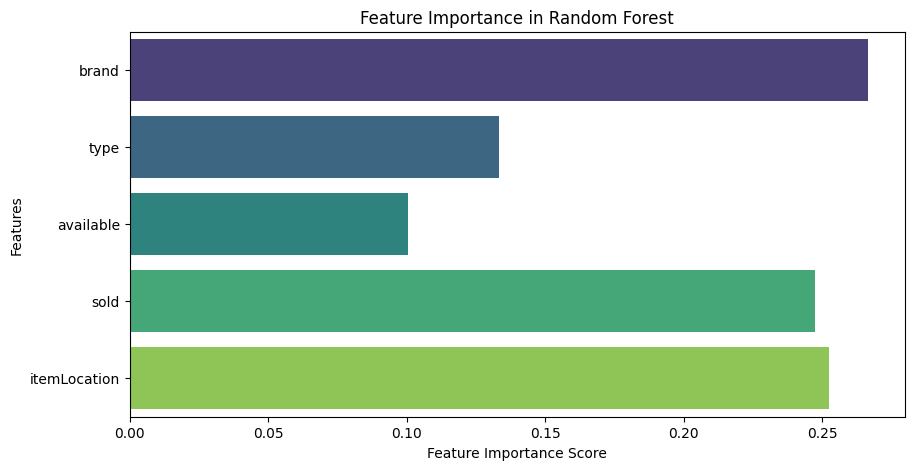

In [9]:
# Select the best-performing model (Random Forest on 80:20 split)
X_train, X_test, y_train, y_test = splits["80:20"]
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Plot feature importance
feature_importance = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=features, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()


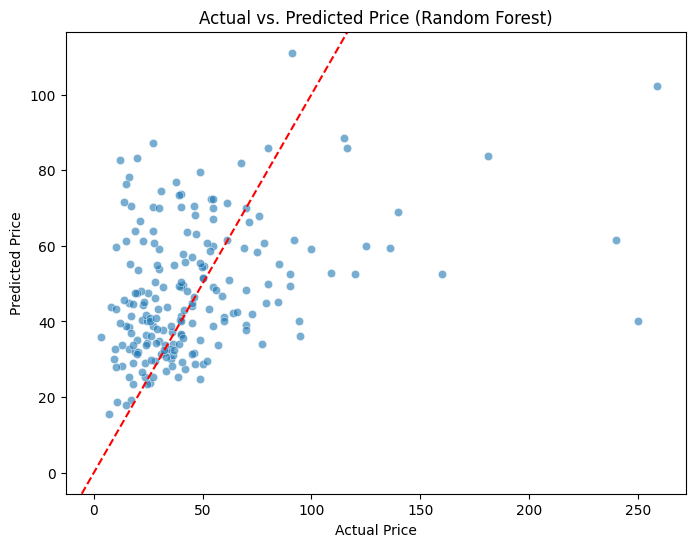

In [10]:
# Predict values using the best model
y_pred = best_model.predict(X_test)

# Plot actual vs predicted prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price (Random Forest)")
plt.axline([0, 0], [1, 1], color="red", linestyle="--")  # Perfect fit line
plt.show()


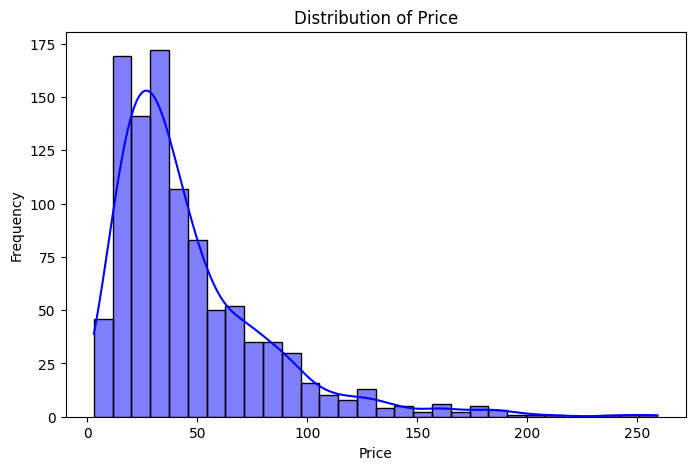

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=30, kde=True, color="blue")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Price")
plt.show()


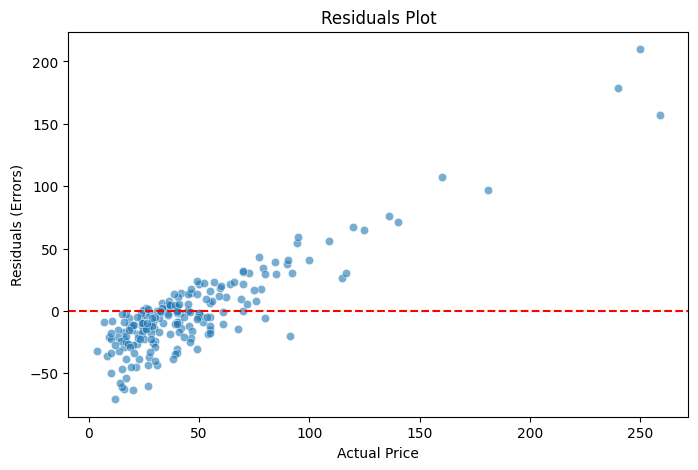

In [12]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Residuals (Errors)")
plt.title("Residuals Plot")
plt.show()


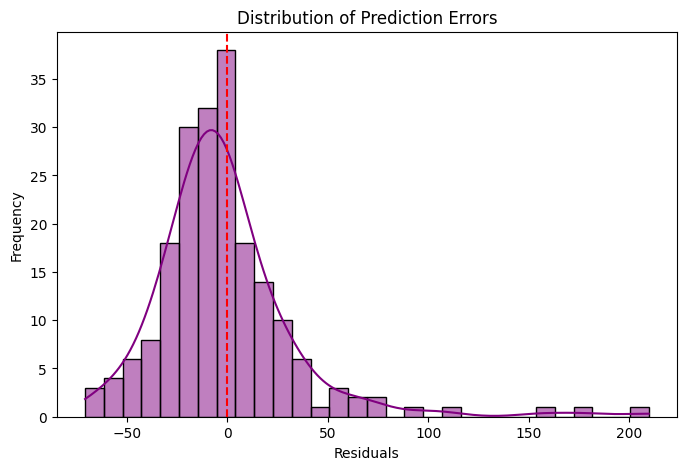

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.axvline(x=0, color="red", linestyle="--")  # Ideal zero-error line
plt.show()


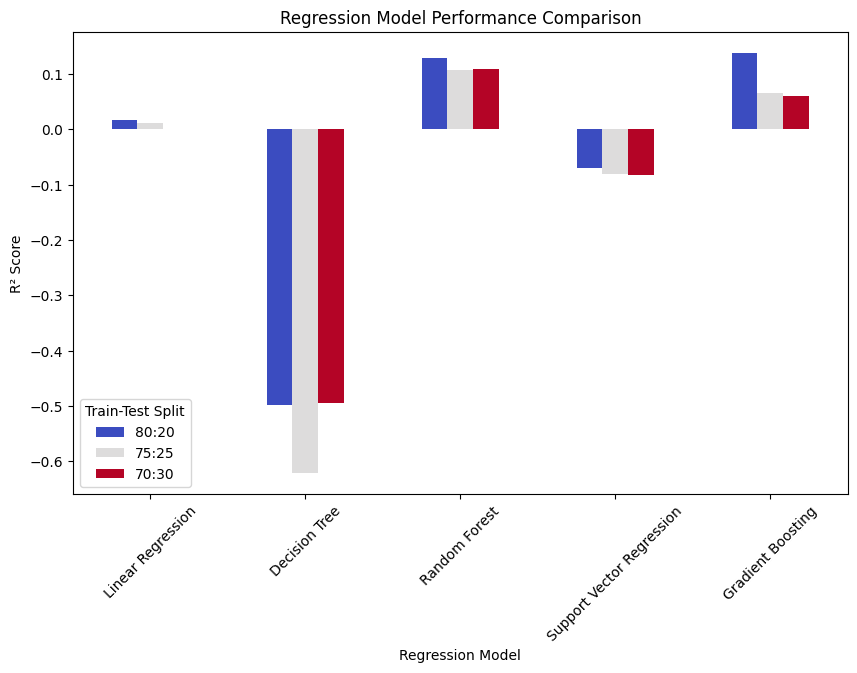

In [14]:
# Extract R2 scores
model_names = list(results.keys())
splits = ["80:20", "75:25", "70:30"]
r2_scores = {split: [results[model][split]["R2"] for model in model_names] for split in splits}

# Plot R2 scores
df_r2 = pd.DataFrame(r2_scores, index=model_names)

df_r2.plot(kind="bar", figsize=(10, 6), colormap="coolwarm")
plt.xlabel("Regression Model")
plt.ylabel("R² Score")
plt.title("Regression Model Performance Comparison")
plt.xticks(rotation=45)
plt.legend(title="Train-Test Split")
plt.show()


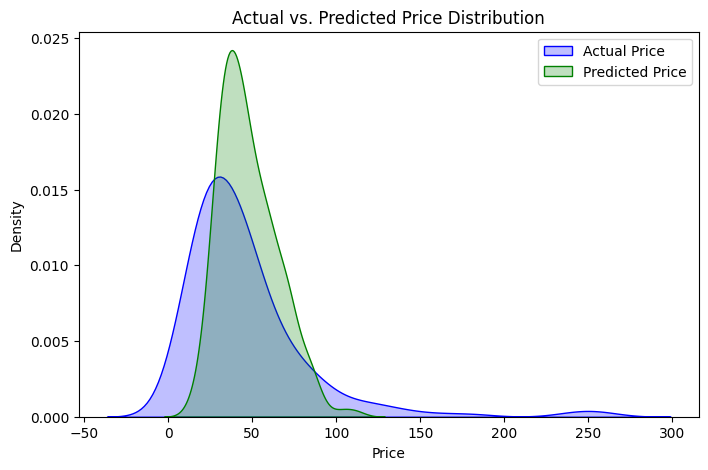

In [15]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, label="Actual Price", color="blue", fill=True)
sns.kdeplot(y_pred, label="Predicted Price", color="green", fill=True)
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Actual vs. Predicted Price Distribution")
plt.legend()
plt.show()


In [16]:
import pandas as pd

# Ensure the 'results' dictionary exists before saving
if 'results' in globals():
    # Convert results dictionary into a DataFrame
    results_df = pd.DataFrame.from_dict(
        {(model, split): metrics 
         for model, splits in results.items() 
         for split, metrics in splits.items()},
        orient='index'
    )

    # Save to Excel file
    excel_filename = "perfume_price_prediction_results.xlsx"
    results_df.to_excel(excel_filename, sheet_name="Model Performance")

    print(f"Results saved successfully in {excel_filename}")
else:
    print("Error: 'results' dictionary is not defined. Run the model training first.")


Results saved successfully in perfume_price_prediction_results.xlsx
